# LP2 Classification Problem

### 1. Business Understanding
#### 1.1 Description 

In today's rapidly evolving telecommunications industry, service providers face intense competition, making the retention of existing customers a critical challenge. It is well-known that the cost of acquiring new customers outweighs that of retaining existing ones. To address this challenge, our project aims to develop a churn prediction model to forecast customer attrition and facilitate targeted retention strategies. 

#### 1.2 Objective  
The primary objective of this project is to create an efficient churn prediction model that can identify customers at risk of churning. By proactively identifying potential churners, the telecom company can take timely and personalized actions to retain valuable customers and prevent revenue loss.  

#### 1.3 Approach 
Our approach involves implementing machine learning techniques for churn prediction. We will explore and compare the performance of two popular algorithms: Logistic Regression, Decision Trees, Random Forest, and Support Vector Machines (SVM). 

  
### 2. Data understanding
There are 3 datasets used in this project. They all contain information about customers in a Telecom company. The following describes the columns present in the data.

* **Gender** -- Whether the customer is a male or a female

* **Partner** -- Whether the customer has a partner or not (Yes, No)

* **SeniorCitizen** -- Whether a customer is a senior citizen or not

* **Dependents** -- Whether the customer has dependents or not (Yes, No)

* **Tenure** -- Number of months the customer has stayed with the company

* **Phone Service** -- Whether the customer has a phone service or not (Yes, No)

* **InternetService** -- Customer's internet service provider (DSL, Fiber Optic, No)

* **MultipleLines** -- Whether the customer has multiple lines or not

* **OnlineSecurity** -- Whether the customer has online security or not (Yes, No, No Internet)

* **OnlineBackup** -- Whether the customer has online backup or not (Yes, No, No Internet)

* **DeviceProtection** -- Whether the customer has device protection or not (Yes, No, No internet service)

* **TechSupport** -- Whether the customer has tech support or not (Yes, No, No internet)

* **StreamingTV** -- Whether the customer has streaming TV or not (Yes, No, No internet service)

* **StreamingMovies** -- Whether the customer has streaming movies or not (Yes, No, No Internet service)

* **Contract** -- The contract term of the customer (Month-to-Month, One year, Two year)

* **PaperlessBilling** -- Whether the customer has paperless billing or not (Yes, No)

* **Payment Method** -- The customer's payment method (Electronic check, mailed check, Bank transfer(automatic), Credit card(automatic))

* **MonthlyCharges** -- The amount charged to the customer monthly

* **TotalCharges** -- The total amount charged to the customer

* **Churn** -- Whether the customer churned or not (Yes or No)


<br>

#### **Installing and importing libraries**


In [1]:
# %pip install pyodbc  
# %pip install python-dotenv
# %pip install imbalanced-learn
# %pip install seaborn
# %pip install  xgboost


In [2]:
# %pip install hyperopt

In [139]:
import pyodbc
from dotenv import dotenv_values 

# Analysis libraries
import pandas as pd 
import numpy as np
from sklearn.impute import SimpleImputer
import re
import datetime
from datetime import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor


#Machine learning libraries
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from scipy.stats import ttest_ind
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score, recall_score, precision_score, f1_score,roc_auc_score,roc_curve#,plot_confusion_matrix
from sklearn.feature_selection import RFE, RFECV
from imblearn.over_sampling import SMOTE
from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics,svm
from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe



# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Warning libraries
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, Markdown
from prettytable import PrettyTable

# Save model
import joblib

#### **Loading data**

In [4]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
database = environment_variables.get("DATABASE")
server = environment_variables.get("SERVER")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")


connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [5]:
# Use the connect method of the pyodbc library and pass in the connection string.
# This will connect to the server and might take a few seconds to be complete. 
# Check your internet connection if it takes more time than necessary

connection = pyodbc.connect(connection_string)

In [6]:
# Now the sql query to get the data is what what you see below. 
# Note that you will not have permissions to insert delete or update this database table. 

query = "Select * from dbo.LP2_Telco_churn_first_3000"
df1 = pd.read_sql(query, connection)
df1.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [7]:
df2=pd.read_csv("data/LP2_Telco-churn-last-2000.csv.")
df2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [8]:
#Checking if columns are same before concatination
print(f'dataset_1: {df1.columns}\n\n\
        dataset_2: {df2.columns}')

dataset_1: Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

        dataset_2: Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [9]:
# Concatenate the DataFrames to get one data set for the work
data=pd.concat([df1,df2])


#### **Previewing the dataset**

In [10]:
#Preview the data
print(data.shape,"\n")
print(data.info())

(5043, 21) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   object 
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-nu

**From the summary above:**
* All columns are string except for ```SeniorCitizen``` ,```tenure ``` and  ```MonthlyCharges```
* There are missing values in several columns.

**From thoroughly examining the dataset, we came out with the following analytical questions:**

* What is the correlation between phone service and churn?
* Do charges contribute to customer churn?
* What is the average tenure of customers?
* How is customer churn aligned with whether a customer has a partner and dependents or not?
* Does being a senor citizen contribute significantly to churn?
* Is customer retention heavily dependent on customer's access to tech support?
* What effect does the online security have on tenure?
* What factors/variables significantly contribute to customer churn?

**Hypothesis Testing**

Hypothesis 1<br>
_**Null:**_ Total charges do not contribute to churn rate among customers.<br>
_**Alternate:**_ Total charges significantly contribute to churn rate among customers.






In [11]:
#Getting unique values for each column
for col in data.columns:
    print(f"Unique values of {col} are {data[col].unique()}\n")

Unique values of customerID are ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

Unique values of gender are ['Female' 'Male']

Unique values of SeniorCitizen are [False True]

Unique values of Partner are [True False 'No' 'Yes']

Unique values of Dependents are [False True 'No' 'Yes']

Unique values of tenure are [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]

Unique values of PhoneService are [False True 'Yes' 'No']

Unique values of MultipleLines are [None False True 'No' 'No phone service' 'Yes']

Unique values of InternetService are ['DSL' 'Fiber optic' 'No']

Unique values of OnlineSecurity are [False True None 'No' 'Yes' 'No internet service']

Unique values of OnlineBackup are [True False None 'No' 'Yes' 'No internet service']

Unique values of DeviceProtection are [F

**Issues arising :**
* Most columns have two values which mean the same thing eg. In ```Partner``` there are values like 'False' and 'No' which mean the same thing.
*  For columns ```MonthlyCharges``` and ```TotalCharges``` , the values should be in a standard decimal place
*  The ```TotalCharges``` column should be converted to float datatype.

### 3. Data preparation

#### 3.1 Data cleaning

**Dealing with duplicates**

In [12]:
data.duplicated().value_counts()

False    5043
dtype: int64

The data contains no duplicates.<br> 

**Data uniformity**

* The ```TotalCharges``` and ```MonthlyCharges``` columns have different decimal places so we are going to standardize the columns to 2 dp. 
* But first of all, the ```TotalCharges``` column needs to be converted to a numeric data type as it is in string format.




In [13]:
#Converting to numric data type
data["TotalCharges"]=pd.to_numeric(data["TotalCharges"],errors="coerce")
data["TotalCharges"].dtype

dtype('float64')

In [14]:
# Selecting numeric and categorical columns
data = data.drop('customerID', axis=1)
numeric_cols = data.select_dtypes('number').columns
categorical_cols = data.select_dtypes('object').columns

#Formatting numeric columns to 2 decimal places
data[numeric_cols]= data[numeric_cols].round(2)



**Cleaning the categorical columns**

In [15]:
# Define a function to convert binary values to 'Yes'/'No'
def convert_to_boolean(df, column):

    # Define a nested function to convert individual values
    def convert_value(value): 
        # Check if the value is True
        if value == True:
            return "Yes"
        # Check if the value is False
        elif value == False:
            return "No"
        # Check if the value is numeric 1
        elif value == 1:
            return "Yes"
        # Check if the value is numeric 0
        elif value == 0:
            return "No"
        # If the value doesn't match any of the above cases, return it as is
        else:
            return value

    # Apply the convert_value function to the specified column of the DataFrame
    df[column] = df[column].apply(convert_value)

    # Return the modified DataFrame
    return df


In [16]:

# Invoke function to convet for all columns in data
for col in categorical_cols:
    data = convert_to_boolean(data, col)

**Cleaning the tenure column**
- It was noticed that there are values with 0 from the ```Tenure ``` column, upon closer inspection the same rows have ```Churn``` as False and ```Totalcharges``` were missing since totalcharges is a product of tenure and monthlycharges. However, its rather odd that if the customers did not stay with the company for more than a month , they should have churned but that is not the case therefore, we will delete these rows.

In [17]:
# Inspecting the `tenure` column
data[data["tenure"] == 0]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,No,Yes,Yes,0,No,None,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,No,No,Yes,0,Yes,No,No,None,None,None,None,None,None,Two year,No,Mailed check,20.25,NaN,No
936,Female,No,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,No,Yes,Yes,0,Yes,Yes,No,None,None,None,None,None,None,Two year,No,Mailed check,25.75,NaN,No
1340,Female,No,Yes,Yes,0,No,None,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
218,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
1670,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No
1754,Male,No,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,NaN,No


In [18]:
# Replace NaN with the median in tenure column using applymap()

data['tenure'] = data[['tenure']].applymap(lambda x: data['tenure'].median() if pd.isnull(x) else x)


In [19]:
# Replace NaN with the median in TotalCharges column using applymap()

data['TotalCharges'] = data[['TotalCharges']].applymap(lambda x: data['TotalCharges'].median() if pd.isnull(x) else x)

**Handling missing values**

In [20]:
#Checking missing values
data.isnull().sum()

gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          0
Churn                 1
dtype: int64


**Decison made:**

* Given that ```OnlineSecurity```, ```OnlineBackup``` ,```DeviceProtection```  ,```TechSupport```, ```StreamingTV```,```StreamingMovies``` and ```Mutliple lines``` are categorical columns, instead of dropping the columns or imputing with the mode , we are going to replace them with 'No internet service' and 'No phone service' respectively. This is because in the real world , if someone doesn't fill an entry for a 'No' or 'Yes' question chances are very high they don't have the particular thing. This is an assumption but one that makes sense.<br>

* For the missing ```Churn``` value ,it will be dropped.

In [21]:

# fill the null categorical values with 'False'
cols_to_replace = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Replace NaN with 'No internet service' in the specified columns using applymap()
data[cols_to_replace] = data[cols_to_replace].applymap(lambda x: 'No internet service' if pd.isnull(x) else x)

# Replace NaN with 'No phone service' in the MultipleLines using applymap()
data['MultipleLines'] = data[['MultipleLines']].applymap(lambda x: 'No phone service' if pd.isnull(x) else x)

#Dropping the missing value row 
data=data.dropna(axis=0,subset=["Churn"])




In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5042 entries, 0 to 2042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5042 non-null   object 
 1   SeniorCitizen     5042 non-null   object 
 2   Partner           5042 non-null   object 
 3   Dependents        5042 non-null   object 
 4   tenure            5042 non-null   int64  
 5   PhoneService      5042 non-null   object 
 6   MultipleLines     5042 non-null   object 
 7   InternetService   5042 non-null   object 
 8   OnlineSecurity    5042 non-null   object 
 9   OnlineBackup      5042 non-null   object 
 10  DeviceProtection  5042 non-null   object 
 11  TechSupport       5042 non-null   object 
 12  StreamingTV       5042 non-null   object 
 13  StreamingMovies   5042 non-null   object 
 14  Contract          5042 non-null   object 
 15  PaperlessBilling  5042 non-null   object 
 16  PaymentMethod     5042 non-null   object 


In [23]:
data.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [24]:
# Save the bridged data as csv file
data.to_csv('data/complete.csv',index=False)

**Inspecting outliers by Visualization**

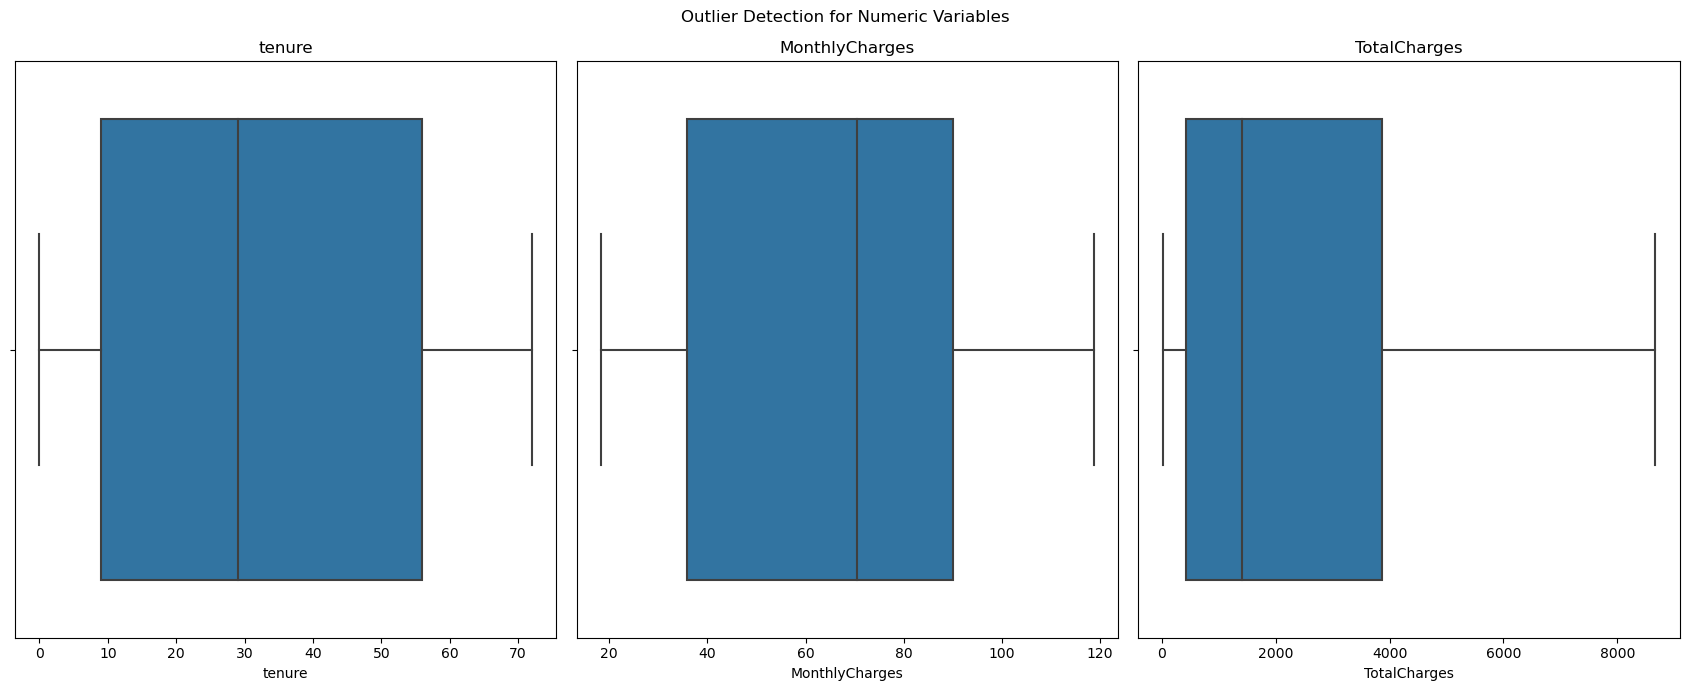

In [25]:
#Plotting box plot to visualize outliers

# Create subplots
fig, axes = plt.subplots(ncols=len(numeric_cols), figsize=(17, 7))

# Loop through numeric columns and create box plots
for i, col in enumerate(numeric_cols):
    if data[col].dtype in ['int64', 'float64']:  # Check if the column is numeric
        sns.boxplot(x=data[col], ax=axes[i])
        axes[i].set_title(col)
    else:
        axes[i].axis('off')  # Disable the plot for non-numeric columns
        print(f"Column '{col}' is not numeric and will not be plotted.")

# Set the main title for the whole plot
title = fig.suptitle('Outlier Detection for Numeric Variables')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

**Observations from outlier analysis.**

*  Our numerical columns are within range ,as no outliers can be seen.  

*  However, `TotalCharges` and `MonthlyCharges` are positively and negatively skewed respectively. 
* `TotalCharges` exhibits a tail that extends towards larger values (4000). Its mean, therefore is greater than the median, which is also greater than the mode.<br>
*  On the other hand, `MonthlyCharges` extends its tail towards the smaller values (40). This indicates a lesser mean than the median, which is also less than the mode

*  The `tenure` column has a near normal distribution.

#### 3.2 Exploratory Data Analysis (EDA).

*  EDA is an essential and crucial initial step in the data analysis process, where the main objective is to gain insights and understanding of the dataset before performing any formal statistical modeling or making inferences.<br> 

* A variety of techniques to summarize, visualize, and interpret crucial characteristics and patterns present in the data are implemented in EDA. 

* EDA encompasses three components: `Univariate`, `Bivariate` and `Multivariate` analysis.

##### 3.2.1. Univariate Analysis
*  Here, we critically examin each variable as a separate entity in terms of statistical distributions.


**EDA of Numeric Variables**

In [26]:
data[numeric_cols].describe()

,tenure,MonthlyCharges,TotalCharges
count,5042.000000,5042.000000,5042.000000
mean,32.568822,65.081376,2299.527063
std,24.525954,30.064564,2266.828751
min,0.000000,18.400000,18.800000
25%,9.000000,35.762500,417.875000
50%,29.000000,70.550000,1401.150000
75%,56.000000,90.050000,3857.012500
max,72.000000,118.650000,8670.100000


`MonthlyCharges`

*With the assumption that the monetary figures are quoted in usd,* 

* The `mean` monthly charge is `65usd`.
* The `least` monthly charge is `18usd`.
* `Median` monthly charge is `71usd`
* `Highest` amount charged per month is `119usd`.


`TotalCharges`

* The `mean` total charge is `2301usd`.
* The `least` total charge is `19usd`.
* `Median` total charge is `1401usd`
* `Highest` amount charged per month is `8670usd`.


`tenure`

* The `mean` tenure is `33 months`.
* The `least` recoreded `0 months`.
* `Median` is `29 months`
* `Highest` amount per month is `72 months`.

**Frequency Distributions of Numerical Variables**

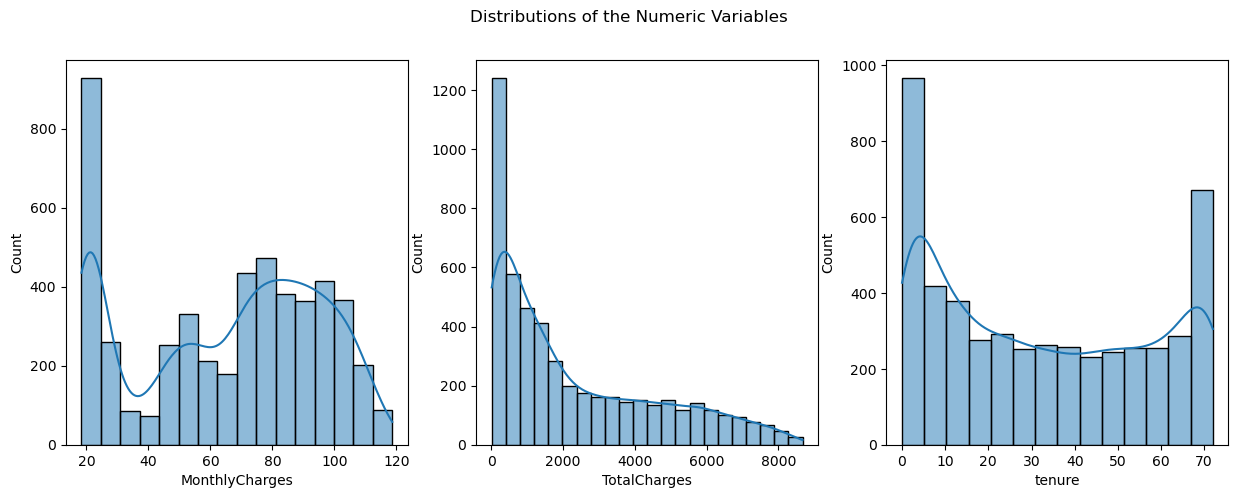

In [27]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # Create a figure and three subplots
sns.histplot(data=data['MonthlyCharges'], kde="Yes", ax=axes[0])  # Plot first figure axes[0]
sns.histplot(data=data['tenure'],kde=True, ax=axes[2])          # Plot third figure axes[2]
sns.histplot(data=data['TotalCharges'], kde="Yes", ax=axes[1])    # Plot second figure axes[1]
title = fig.suptitle('Distributions of the Numeric Variables');         # Give general title

**Summary**<br>
`MonthlyCharges`
* The highest(near `1000`) number of customers have very low monthly charges from about `18` usd to `25` usd.
* The middle class was charged between `50` to `100` usd.
* The top users incured above `100` usd.



`TotalCharges`

* Majority of customers have total charges below `2000` usd.
* The middle class was charged between `2000` to `6000` usd in total.
* The top users incured above `6000` usd as their total charges.


`tenure`

* Most customers have tunure of `5` months and less and above `65` months.
* On average, customers' tenure is about `35` months.

**EDA of Categorical Variables**

Get the statistical summary about the categorical variables

In [28]:
# Get the statistical distribution

data[categorical_cols].describe()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,5042,5042,5042,5042,5042,5042,5042,5042,5042,5042,5042,5042,5042,5042,5042,5042,5042
unique,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,Male,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,2558,4223,2585,3481,4553,2424,2247,2507,2231,2219,2471,2018,1981,2744,2995,1699,3706


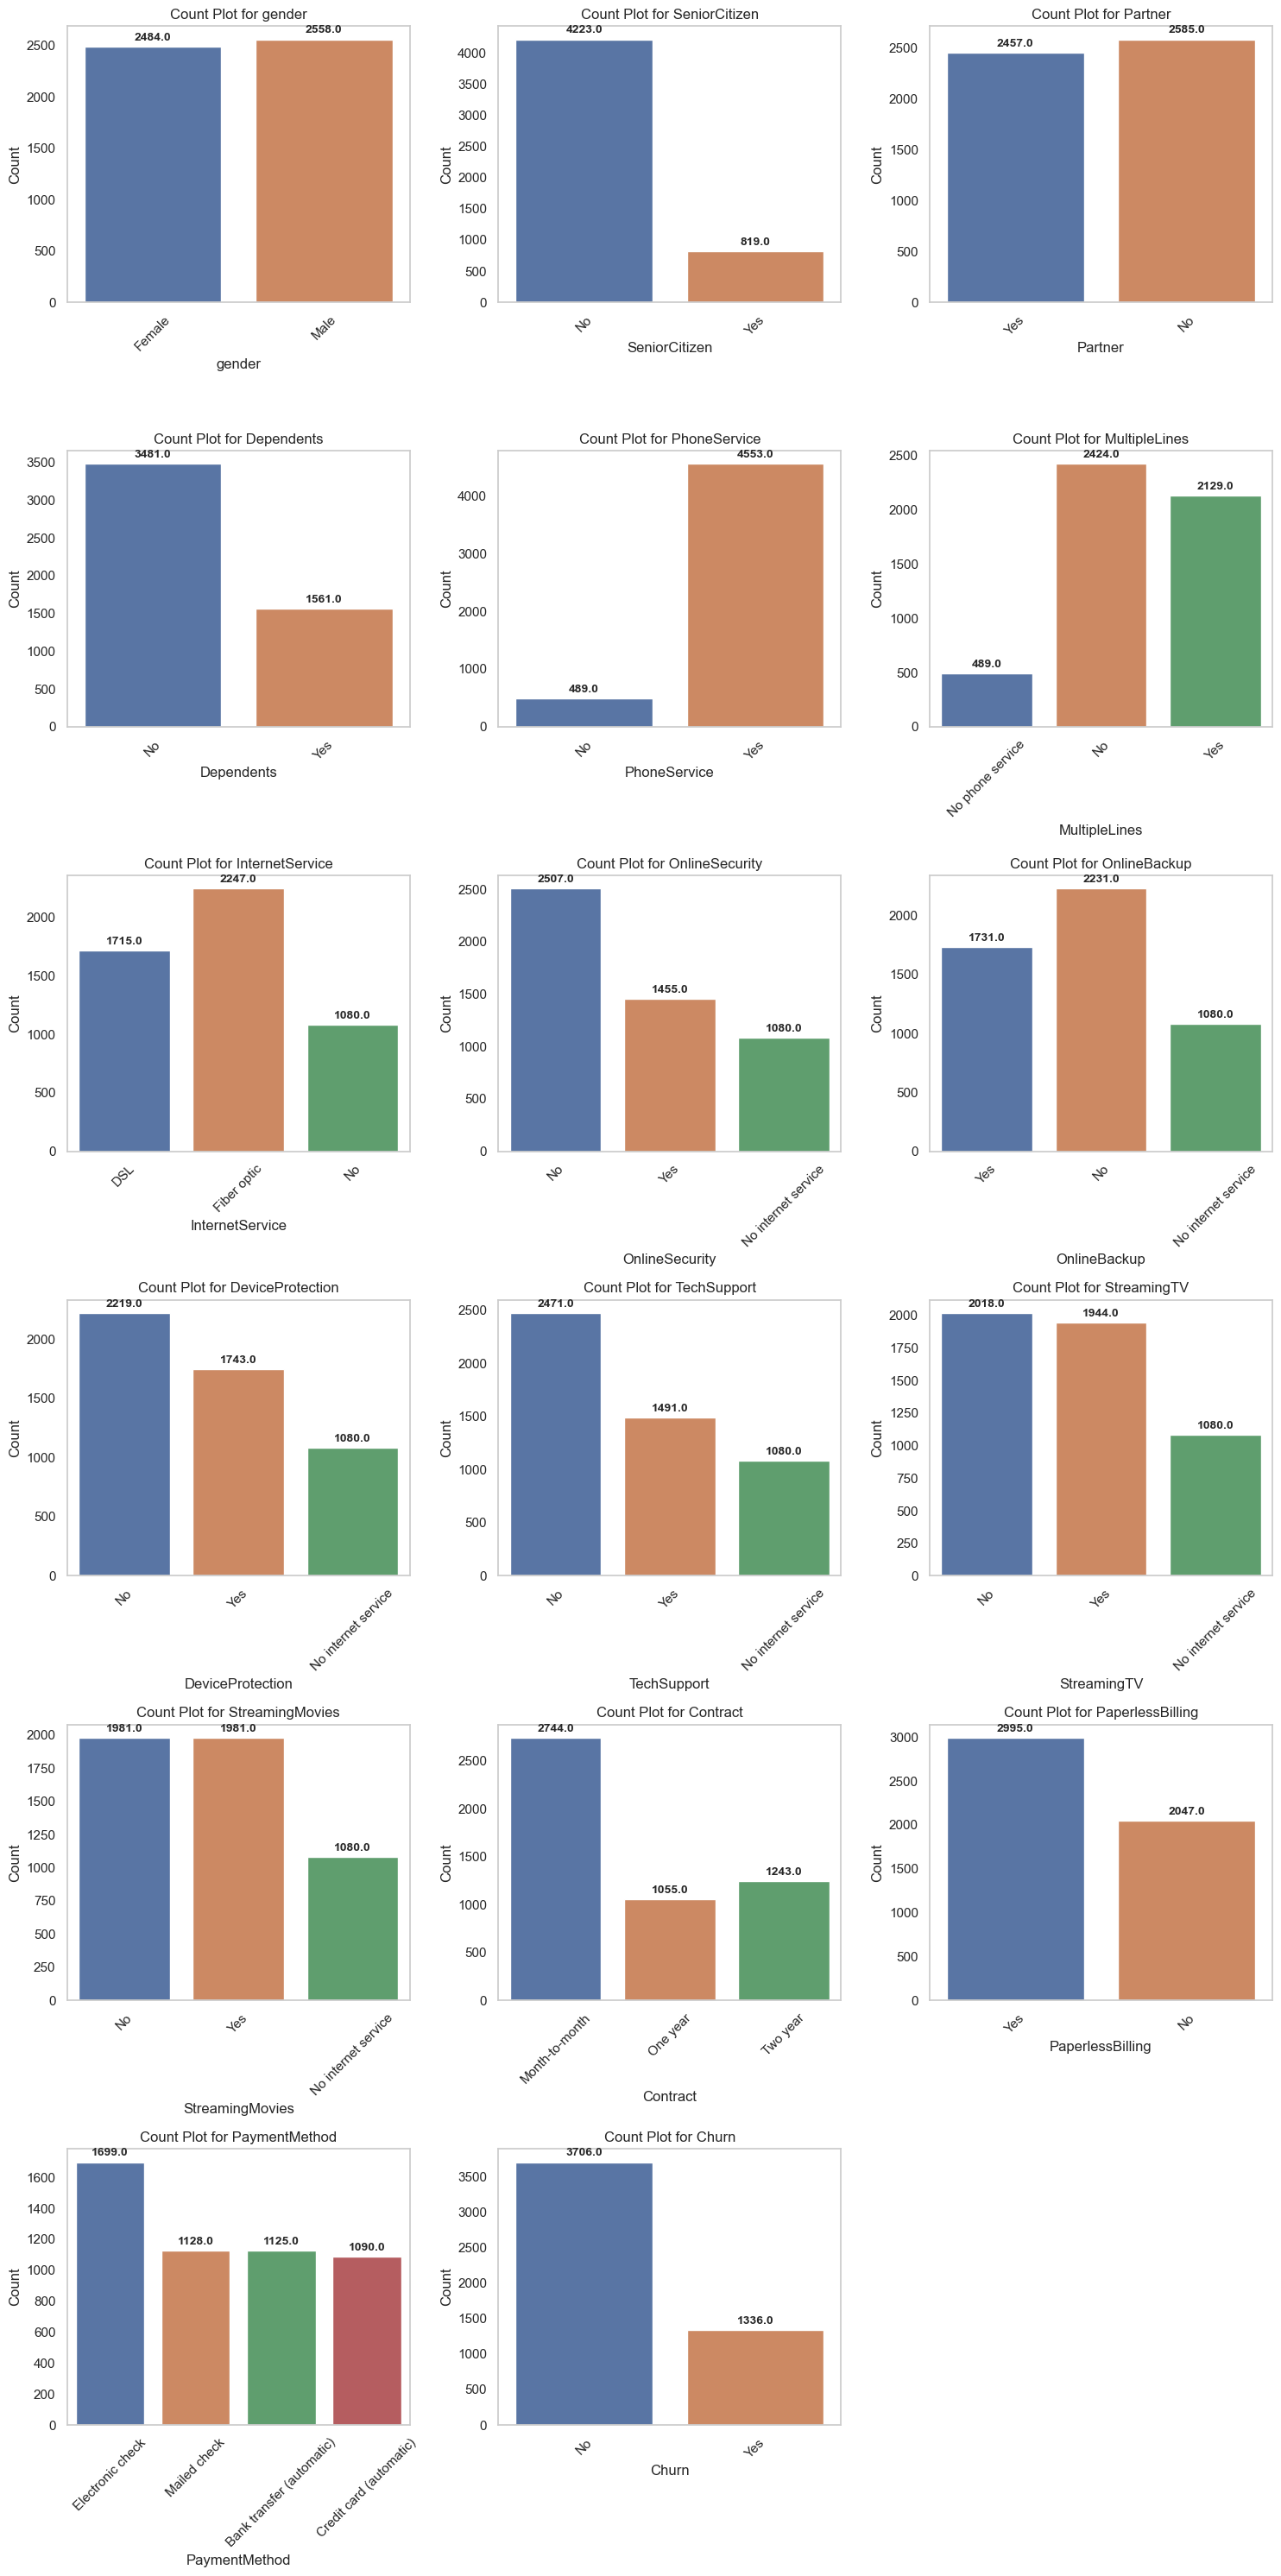

In [29]:
# Calculate the number of rows and columns for subplots
num_cols = 3
num_rows = (len(categorical_cols) - 1) // num_cols + 1

# Plot count plots for all categorical columns
sns.set(style="whitegrid")
plt.figure(figsize=(5 * num_cols, 5 * num_rows))

for i, col in enumerate(categorical_cols):
    plt.subplot(num_rows, num_cols, i + 1)
    ax = sns.countplot(x=col, data=data[categorical_cols])
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.title(f"Count Plot for {col}")
    plt.xticks(rotation=45)

    # Add count values above each bar
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', xy=(p.get_x() + p.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.grid(False)

plt.tight_layout()  # To improve subplot spacing
plt.show()

**Summary on Observations :**

`Gender`<br>
For this data, gender refers to whether male or female.
There are more males than females. They account for `51% `of customers.

`Seniorcitizen`<br>
Majority of customers are not senior citizens. Out of the 5042 customers, only `819` are 60 or 65 years old and maybe are pensioners.

`Partner`<br>
Customers without partner exceed those with partner with just `128`.

`Dependents`<br>
This variable refers to whether a customer has dependents or not. From the visualization, `3481` customers have no dependents.

`Phoneservice`<br>
For whether or not a customer had subscribed to phone service, `4553`, representing 90% did subscribe.


`Multiplelines`<br>
Among the three unique options to this variable, without multiple lines outweighs the rest. `2693`customers did not have multiple lines.

`Internetservice`<br>
The internet service variable pertains to whether a customer opted for DSL, fiber optic or none. From the statistical summary, `2247`customers subscribed to fiber optic. 

`Onlinesecurity`<br>
More customers (`3158`) did not adopt the online security service.

`Onlinebackup`<BR>
Out of the 5042 customers, `2882` did not subscribe to online backup.

**Examining the Target Variable**

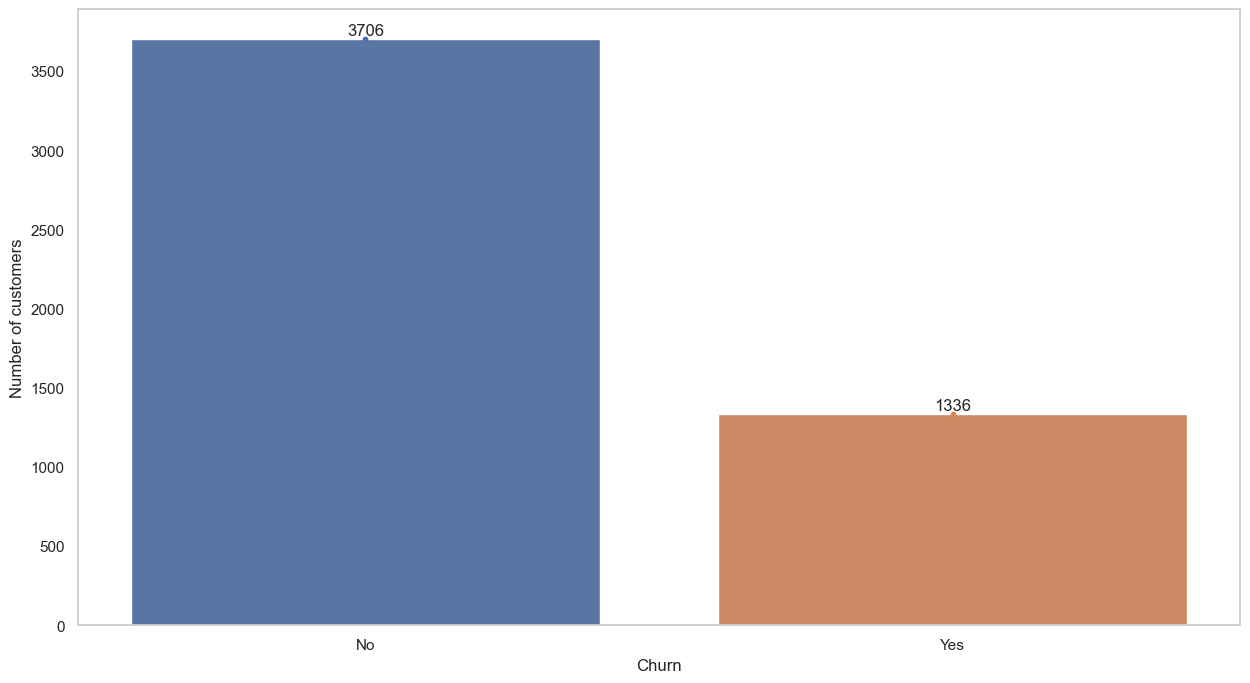

In [30]:
churn_rate=data["Churn"].value_counts()
plt.figure(figsize=(15,8))
sns.countplot(x=data["Churn"])
plt.ylabel("Number of customers")
for index, value in enumerate(churn_rate):
    plt.scatter(index, value, s=10)  # s=100 for marker size
    plt.annotate(str(value), xy=(index, value), xytext=(index, value+1),
                 ha='center', va='bottom', fontsize=12)

# Remove the grid lines
plt.grid(False)



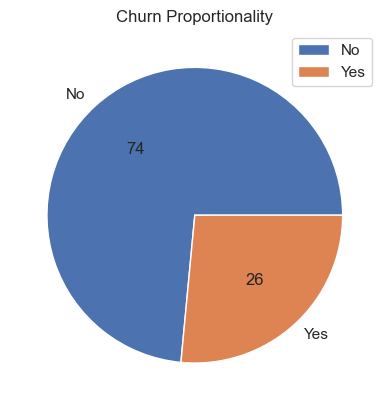

In [31]:
plt.pie(data.Churn.value_counts(),
        labels= ['No', 'Yes'],
        autopct='%.f', normalize=True)
plt.title('Churn Proportionality')
plt.legend()
plt.show()

 **Conclusion on the Churn rate**
* There are 3692 customers that remained in the company which is 73% of the customers while 1334 (27% of the customers)  churned meaning the retention rate is higher than the churn rate.
* There is also a class imbalance in the target variable as there is unequal distribution of classes in the dataset. This issue will later be addressed as the machine learning classifier tends to be more biased towards the majority class, causing bad classification of the minority class

##### 3.2.2 Bivariate analysis

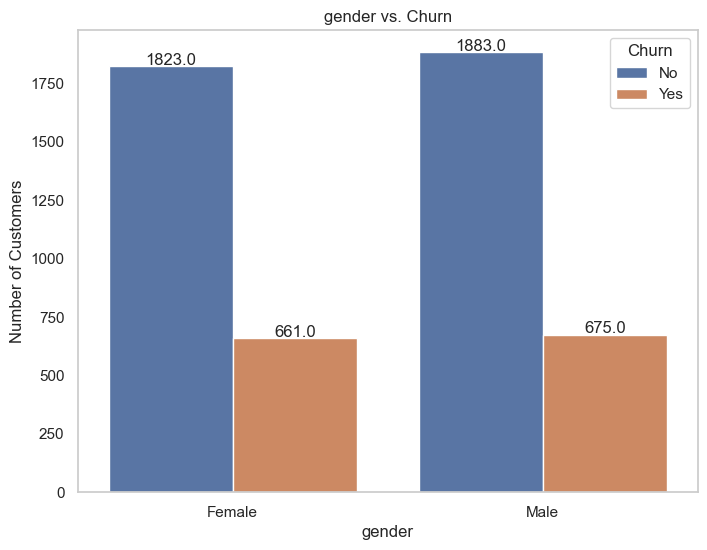

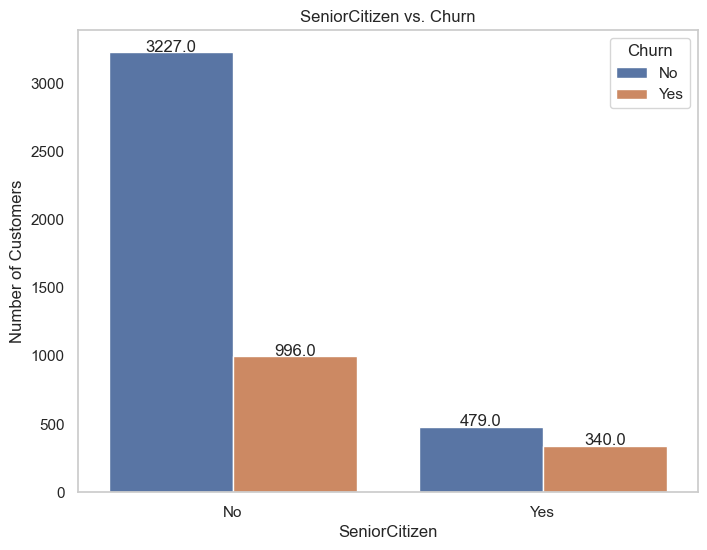

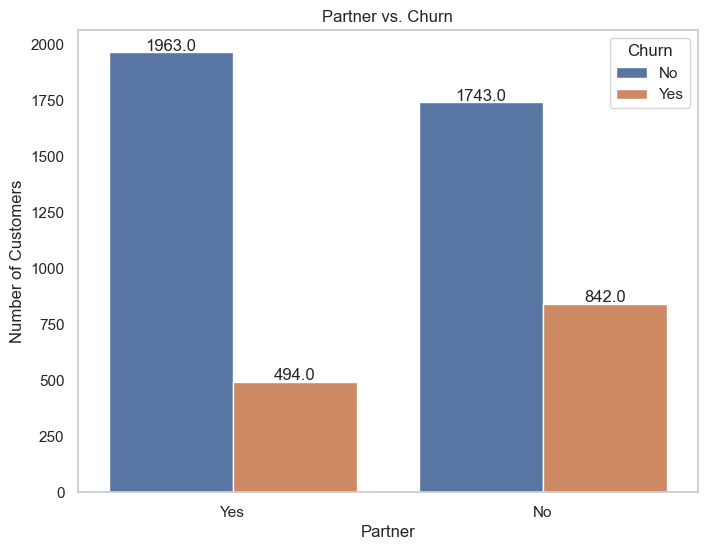

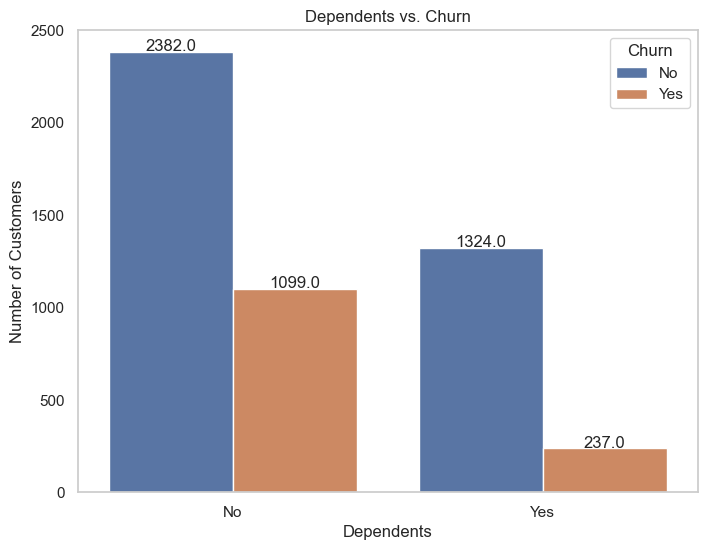

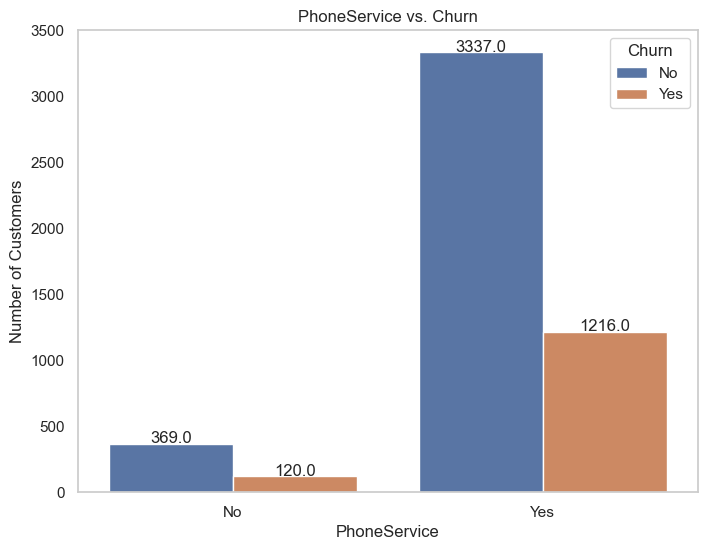

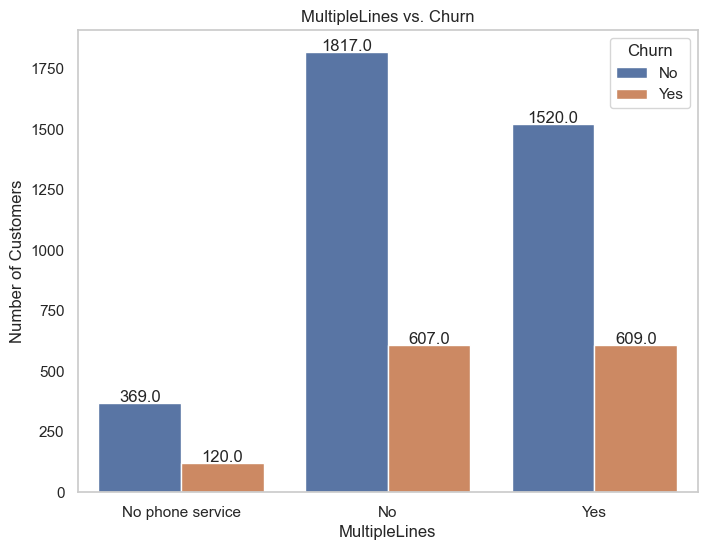

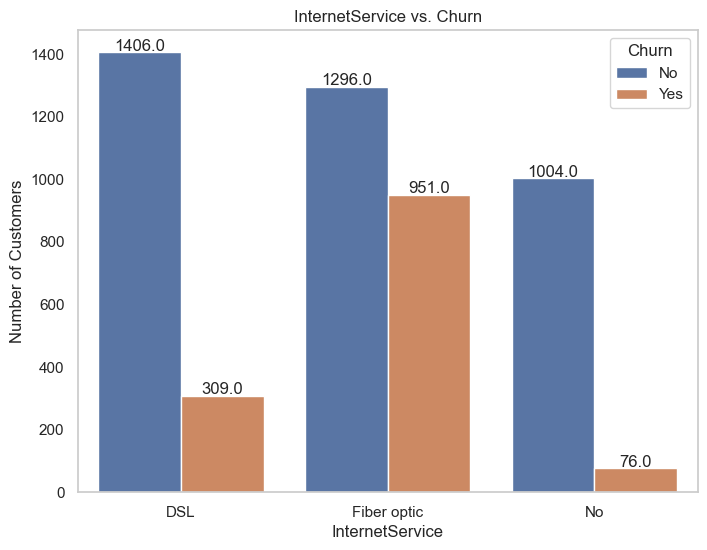

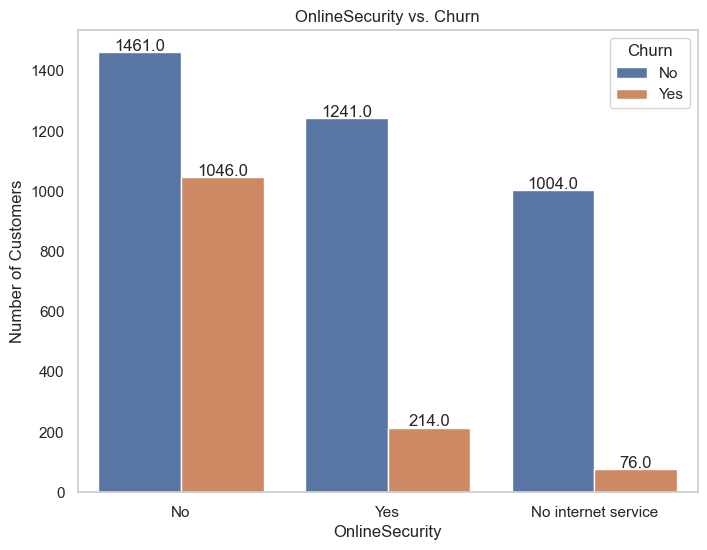

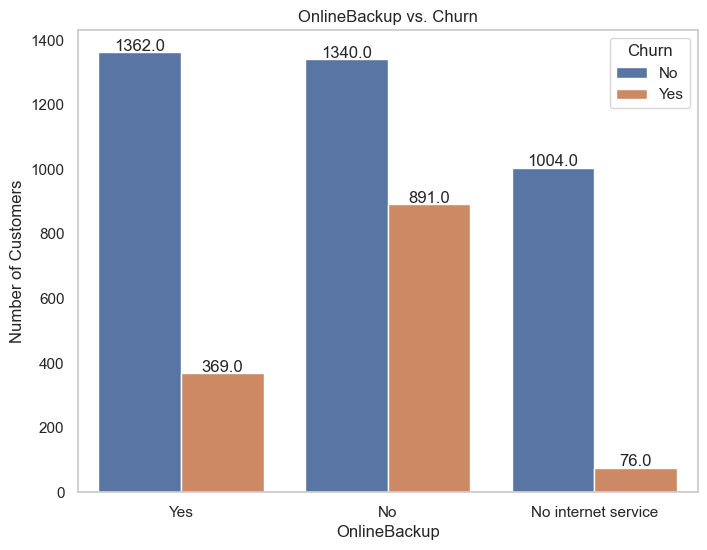

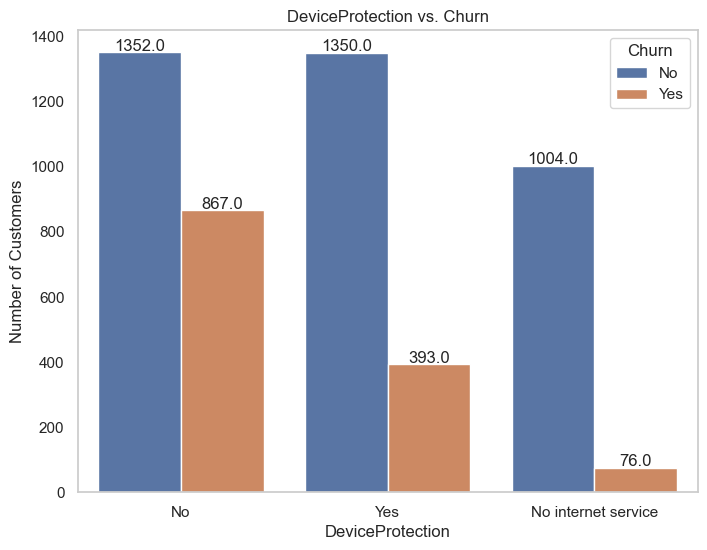

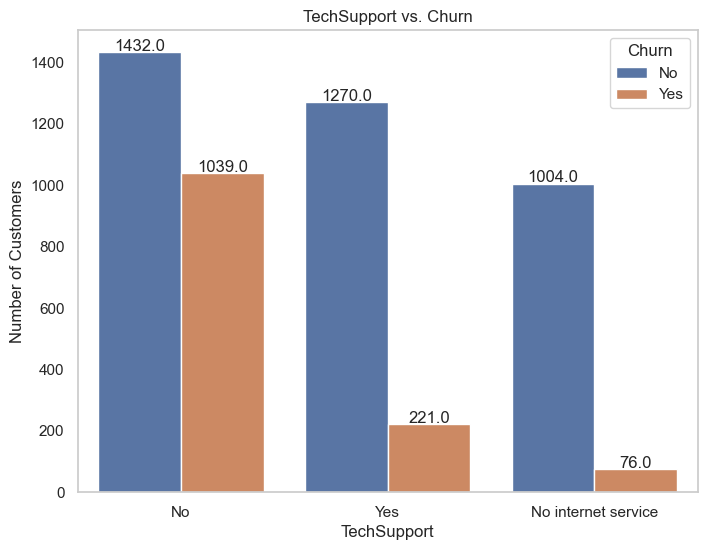

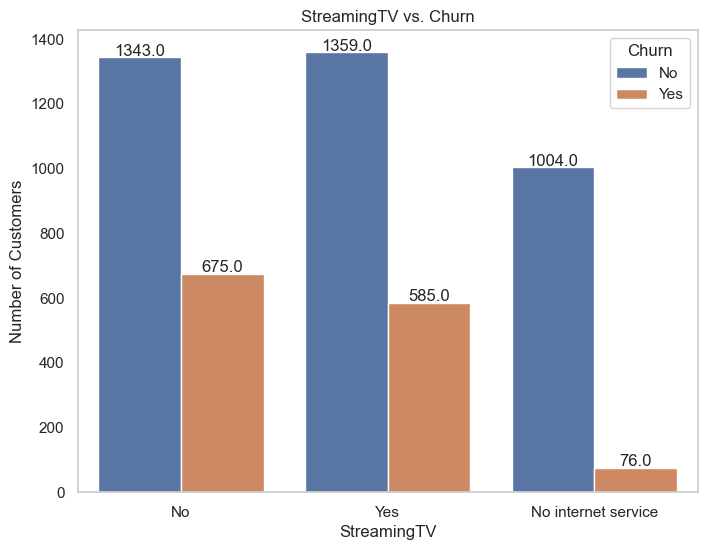

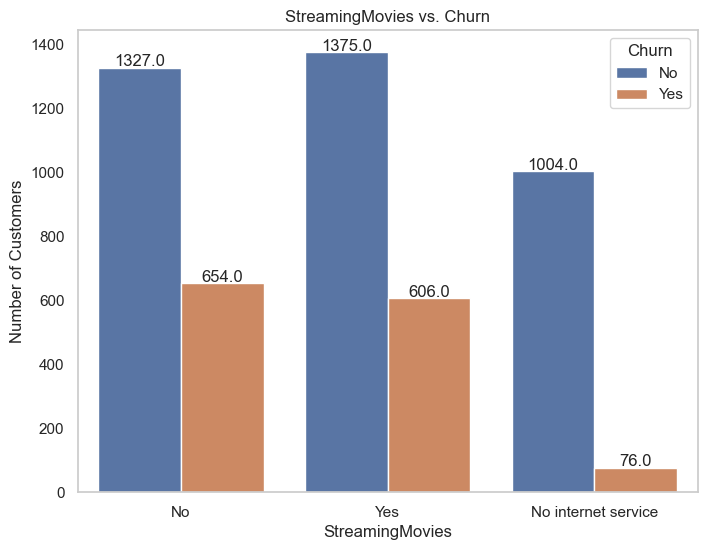

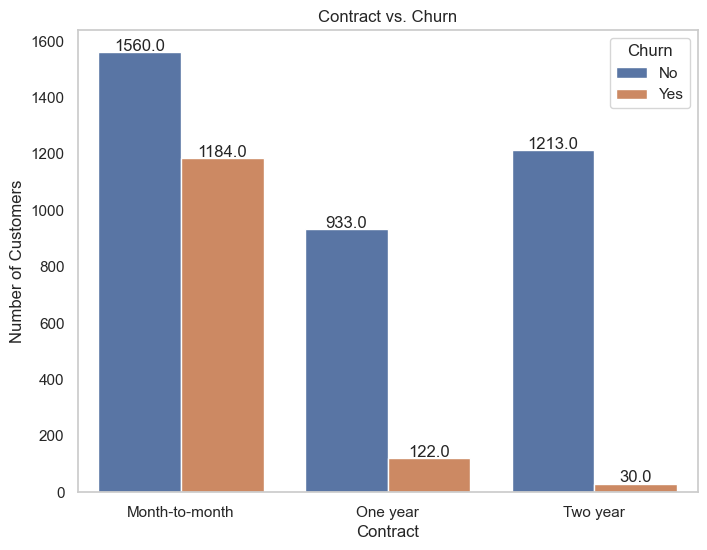

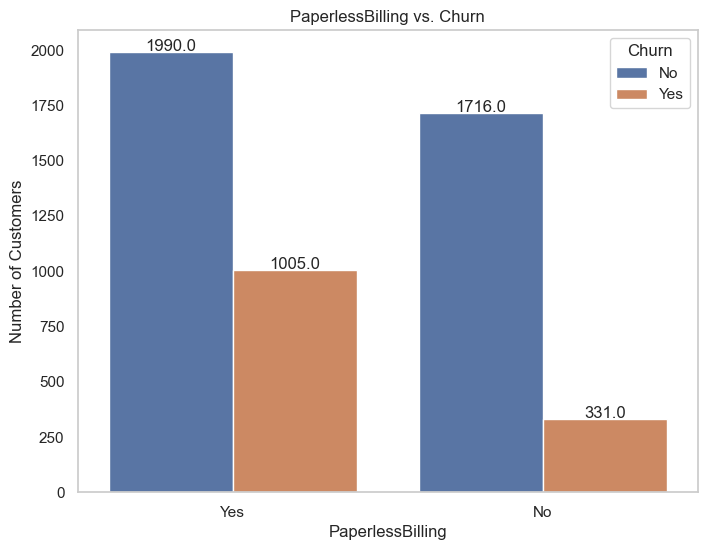

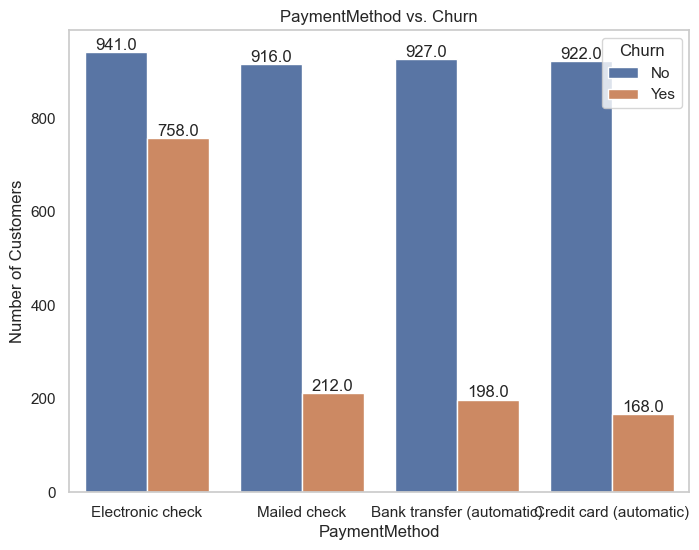

In [32]:


visualization_categorical_variables = categorical_cols.drop('Churn')
for var in visualization_categorical_variables:
    plt.figure(figsize=(8, 6))
    ax=sns.countplot(x=var, hue='Churn', data=data)
    plt.xlabel(var)
    plt.ylabel('Number of Customers')
    plt.title(f'{var} vs. Churn')
    plt.legend(title='Churn', loc='upper right')

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height + 5, f'{height}', ha='center')

    plt.grid(False)
    plt.show()

 


**Summary of Visualizations**

* Males are likely to leave the company more than females. The males are also likely to stay in the company more than females.

*  More senior citizens are likely to stay in a company than quit.

*  Those with partners are more likely to stay in a company as opposed to those without partners who are more likely to quit a company.

*  Those without dependents are more likely to quit the company unlike those with dependents.

* Phone service affects greatly if a customer will churn or not.

* Customers that use multiple lines are likely to stay in a company as opposed to others.

* Most customers that stayed in the company are those that used DSL internet service.
* Most customers that don't use online security are likely to stay in the company.
* Usage of online backup doesn't make a customer stay since most customers that stayed did not utilize the online backup services.
* Technical support can make a customer stay or leave since those that didn't use technical support were the highest contributor to a customer leaving or staying.
* A contract period contributes to churn rate. The shorter the contract term, the higher the rate of churn.
* Paperless billing is a major contributor to a customer not churning. Those that use paperless billing are more likely to stay.
* Most customers that left are those that used electronic check as the method of paying.


### 3.3. Data preprocessing.

Data preprocessing is an integral step in Machine Learning as the quality of data and the useful information that can be derived from it directly affects the ability of our model to learn; therefore, it is extremely important that we preprocess our data before feeding it into our model.It shall involve te following steps:

1. Splitting data into train and test
2. One-hot encoding categorical data
3. Dealing with multicollinearity
4. Dealing with class imbalance in the target variable
5. Dimensionality reduction
6. Scaling the data

In [33]:
data.sample(4)  #Get 4 samples of the data

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2776,Male,Yes,Yes,No,16,Yes,No,Fiber optic,No,Yes,No,No,No,No,Month-to-month,Yes,Credit card (automatic),74.30,1178.25,Yes
1336,Female,No,Yes,No,15,Yes,No,Fiber optic,No,Yes,No,No,No,No,Month-to-month,No,Bank transfer (automatic),75.35,1114.55,No
1120,Male,No,No,No,6,Yes,No,DSL,No,Yes,No,No,Yes,No,Month-to-month,No,Electronic check,59.45,357.60,No
2683,Female,No,No,No,7,Yes,Yes,Fiber optic,Yes,No,No,No,No,No,Month-to-month,Yes,Mailed check,79.65,604.70,Yes


##### **Splitting the data to train and test**

Splitting the dataset into train and test sets is one of the important parts of data pre-processing, as by doing so, we can improve the performance of our model and hence give better predictability. Also it helps avoid overfitting

In [34]:
# partion features and target 
X=data.drop("Churn",axis=1)
y= data["Churn"]

# train test split
X_train, X_val, y_train, y_val= train_test_split(X, y,test_size=0.2, random_state =42, stratify=y)

In [35]:
#Previewing the shape of dataset(splits)
print(f"The shape for X_train is {X_train.shape}")
print(f"The shape for X_val is {X_val.shape}")
print(f"The shape for y_train is {y_train.shape}")
print(f"The shape for y_val is {y_val.shape}")

The shape for X_train is (4033, 19)
The shape for X_val is (1009, 19)
The shape for y_train is (4033,)
The shape for y_val is (1009,)


##### **One Hot Encoding**

In [36]:
# Drop Churn so we can apply categorical_cols
categorical_cols = categorical_cols.drop(["Churn", "gender"])

In [37]:
# Apply transformers using ColumnTransformer with output as a pandas DataFrame
# Apply 'scale' transformer to numeric_cols and 'encode' transformer to categorical_cols
# Output the results as a pandas DataFrame

transform_encode = ColumnTransformer([
        ('scale', StandardScaler(), numeric_cols),
        ('encode', OneHotEncoder(sparse=False), categorical_cols),
    ]).set_output(transform='pandas')

In [38]:
# Fit and transform on training data using the defined transformers
X_train = transform_encode.fit_transform(X_train)

# Transform validation data using the same transformer
X_val = transform_encode.transform(X_val)



**Binary Classification for the Train Target(Churn)**

In [39]:
# Encode y, the target

y_train=y_train.apply(lambda x: 1 if x in ['Yes'] else 0)
y_val=y_val.apply(lambda x: 1 if x in ['Yes'] else 0)


##### **Multicollinearity**
**Investigating correlated independent variables**

In [40]:

#Pairs of highly correlated independent variables
df = X_train.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df['pairs'] = list(zip(df.level_0, df.level_1))

df.set_index(['pairs'], inplace = True)
df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
df.columns = ['cc']

df.drop_duplicates(inplace=True)

df[(df.cc>.75) & (df.cc<1)]

,cc
pairs,
"(encode__MultipleLines_No phone service, encode__PhoneService_Yes)",1.000000
"(encode__Dependents_No, encode__Dependents_Yes)",1.000000
"(scale__TotalCharges, scale__tenure)",0.826551
"(encode__MultipleLines_Yes, encode__MultipleLines_No)",0.824370
"(scale__MonthlyCharges, encode__InternetService_Fiber optic)",0.789850
"(encode__OnlineSecurity_No internet service, scale__MonthlyCharges)",0.763643


* These pairs of independent variable have a high correlation between them which might lead to multicollinearity.Multicollinearity can lead to skewed or misleading results when  attempting to determine how well each independent variable can be used most effectively to predict or understand the dependent variable in a statistical model.<br>
* Inorder to detect and deal with multicollinearity, we'll use Variance Inflation Factor(VIF) to detect it then do a feature selection and drop variables with a high VIF value.


Control Multicollinearity by dropping one of the highly correlated pairs

In [41]:
X_train = X_train.drop(['encode__PaperlessBilling_No', 'encode__MultipleLines_No', 'encode__InternetService_Fiber optic', 'encode__StreamingMovies_No internet service', 'encode__InternetService_No', 'encode__OnlineBackup_No internet service', 'encode__StreamingTV_No internet service'], axis=1)

X_val = X_val.drop(['encode__PaperlessBilling_No', 'encode__MultipleLines_No', 'encode__InternetService_Fiber optic', 'encode__StreamingMovies_No internet service', 'encode__InternetService_No', 'encode__OnlineBackup_No internet service', 'encode__StreamingTV_No internet service'], axis=1)


##### **Data Balancing using SMOTE**

In [42]:
# Check distribution for the target variable
y_train.value_counts()

0    2964
1    1069
Name: Churn, dtype: int64

There is an imbalance in the distribution of the target (churn).

Imbalanced datasets mean that the number of observations differs for the classes in a classification dataset. <br>This imbalance can lead to inaccurate results as the model performance could be having  better scores when actually the scores are mostly representative of the class with the more weight. One good technique to handle this is using SMOTE (Synthetic Minority Over-sampling Technique)

SMOTE, as the name implies augments the minority class by creating synthetic samples.

In [43]:
# Applying SMOTE to the target

smote = SMOTE(random_state=42) # Initialize the ojbect of smote
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) # Apply the object to our train sets

In [44]:
y_train_resampled.value_counts()  # Validate the balance

1    2964
0    2964
Name: Churn, dtype: int64

### 4. **Model Training**

For this we shall explore the following algorithms:
* Logistic Regression
* Random Forest
* K- Nearest Neighbour
* Support Vector Machine
* XGBClassifier

#### 4.1.  Logistic Regression

In [45]:
# Training the train sets on logistic regression


logistic_model=LogisticRegression()  # Create an instance of Logistic Regression
logistic_model.fit(X_train_resampled,y_train_resampled)  # Train the train set 
y_predicted_logistic=logistic_model.predict(X_val)  # Validate with the validation set

##### Evaluating our model
**Confusion matrix**

A confusion matrix is a fundamental tool for evaluating the performance of classification models. It provides a more detailed understanding of how well a model is performing by breaking down the predictions into different categories based on the actual and predicted class labels. A confusion matrix is especially useful when dealing with imbalanced classes, multiple classes, or when you want to know more about the types of errors your model is making.

In [46]:
# A function to plot confusion matrix of a model, compute metrics and present them in a dataframe

def evaluate(model, val, predicted):
    """
    Evaluate the performance of a classification model using a combination of visualizing
    a confusion matrix and calculating various performance scores.

    Parameters:
        model (sklearn.base.BaseEstimator): A trained classification model.
        val (array-like): The true labels of the val data.
        predicted (array-like): The predicted labels by the model for the val data.

    Returns:
        pandas.DataFrame: A DataFrame containing various performance scores.

    This function takes a trained classification model, the true labels of the val data,
    and the predicted labels by the model. It first visualizes the confusion matrix to provide
    a graphical representation of the classification results. It then calculates and displays
    various performance scores, including Accuracy, Recall, Precision, F1-Score, and ROC AUC.

    The function uses the scikit-learn's metrics module to calculate the confusion matrix
    and the mentioned performance scores. The confusion matrix is displayed using the
    ConfusionMatrixDisplay class from the sklearn.metrics.plotting module. The function
    returns a DataFrame containing the calculated scores for easy reference and comparison.

    Example:
        # Assuming 'model', 'X_val', and 'y_predicted' are defined
        scores = evaluate(model, y_val, y_predicted)
        print(scores)

    Note:
        - Ensure that the required libraries (sklearn, pandas, matplotlib) are imported before using the function.
        - The 'model' parameter should be a trained classification model that supports the 'classes_' attribute.
    """
    # Calculate the confusion matrix and display it
    cm = metrics.confusion_matrix(val, predicted, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.title(f'Confusion Matrix for {model}')
    plt.grid(False)
    plt.show()

    # Calculate the scores
    scores = {
        'Accuracy': accuracy_score(val, predicted),
        'Recall': recall_score(val, predicted),
        'Precision': precision_score(val, predicted),
        'F1-Score': f1_score(val, predicted),
        'ROC AUC': roc_auc_score(val, predicted)
    }

    # Create a DataFrame from the scores
    scores_df = pd.DataFrame.from_dict(scores, orient='index', columns=['Score'])

    # Display the DataFrame
    
    return scores_df


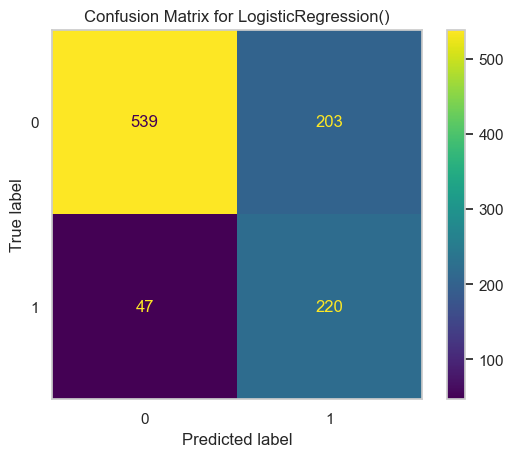

,Score
Accuracy,0.752230
Recall,0.823970
Precision,0.520095
F1-Score,0.637681
ROC AUC,0.775193


In [47]:
# Invoke the evaluate() function on the model trained.
evaluate(logistic_model, y_val, y_predicted_logistic)

From the confusion matrix diagram,:
* The ***True Negatives*** are `539`. This implies that 552 true labes for 0 (churn=false) were acurately predicted out of `747` (539+203).
* The ***False Positives*** are `203`. 195 labels were thus misclassified as positive(1) instead of being negatives (0).
* The ***False Negatives*** are `47`. 54 labels were missclassified as negatives(0) instead of being positives(1).
* The ***True Positves*** are `220`. We accurately predicted 205 positives out of 159 positives which are true.

`Accuracy`: 

Accuracy measures the proportion of correctly classified instances out of the total instances. An accuracy of `0.752` indicates that your model is correctly predicting the target class for around `75.2%` of instances. While accuracy is a common metric, it might not be the most informative one, especially for imbalanced datasets.

`Recall`: 

Recall (also known as sensitivity or true positive rate) measures the proportion of actual positive instances that were correctly classified as positive by the model. A recall of `0.824 `suggests that the model is able to correctly identify about `82.4% `of the actual positive cases. High recall is desirable, especially when you want to minimize false negatives (e.g., in medical diagnoses).

`Precision`: 

Precision measures the proportion of predicted positive instances that were actually positive. A precision of `0.520` indicates that out of all instances predicted as positive by the model, only around `52%` were truly positive. Precision is important when you want to minimize false positives (e.g., in fraud detection), but it needs to be balanced with recall.

`F1-Score`: 

The F1-score is the harmonic mean of precision and recall. It provides a balanced view of the model's performance, considering both false positives and false negatives. An F1-score of `0.638` indicates a balance between precision and recall, but there's room for improvement.

`ROC AUC`: 

The ROC AUC (Receiver Operating Characteristic Area Under the Curve) is a measure of the model's ability to distinguish between the two classes across different threshold settings. An ROC AUC of `0.775` suggests that the model has good discriminative power, but there might still be areas for improvement.

Check for underfitting or overfitting

In [48]:
#Defining a function that scores the model to check for overfitting or underfitting.


def score(model, x_train, y_train, x_val, y_val):
    """
    Calculate and display the training and testing scores of a given model.

    Parameters:
        model (sklearn.base.BaseEstimator): A trained machine learning model.
        x_train (array-like): The feature matrix of the training data.
        y_train (array-like): The target labels of the training data.
        x_test (array-like): The feature matrix of the testing data.
        y_test (array-like): The target labels of the testing data.

    This function calculates and displays the training and testing scores of a given
    machine learning model. The training score is the accuracy of the model on the
    training data, and the testing score is the accuracy of the model on the testing data.
    
    The function uses the `score` method of the provided model to calculate the accuracy
    on both the training and testing datasets. The scores are then printed to the console
    for easy reference and comparison.

    Example:
        # Assuming 'model', 'X_train', 'y_train', 'X_test', and 'y_test' are defined
        score(model, X_train, y_train, X_test, y_test)

    Note:
        - Ensure that the required libraries (sklearn) are imported before using the function.
    """
    # Calculate training and testing scores
    train_score = model.score(x_train, y_train)
    test_score = model.score(x_val, y_val)
    
    # Print the scores
    print(f"Train score: {train_score:.4f}\nTest score: {test_score:.4f}")

    


In [49]:

# Invoke the function-score() to get train and test scores

score(logistic_model,X_train_resampled,y_train_resampled,X_val,y_val)

Train score: 0.7901
Test score: 0.7522


The train score is `79%` and that of test is `75%`.

Since Both train and test scores exhibited `no` significant differences, <br>
we conclude there is neither underfitting nor overfitting.

#### 4.2 Random Forest

In [50]:
#Instantiate a pipeline
pipeline3=Pipeline([('RF', RandomForestClassifier())])

rf_param_grid = {
    'RF__n_estimators': [10, 50, 100],
    'RF__criterion': ['gini', 'entropy'],
    'RF__max_depth': [None, 2, 6, 10],
    'RF__min_samples_split': [5, 10],
    'RF__min_samples_leaf': [3, 6]
}

rf_grid_search = GridSearchCV(pipeline3, rf_param_grid, cv=3)
rf_grid_search.fit(X_train_resampled, y_train_resampled)

# Print the test and train score
score(rf_grid_search,X_train_resampled, y_train_resampled,X_val,y_val)



Train score: 0.9318
Test score: 0.7929




This score of approximately `93%` indicates that the model achieved an accuracy of around `93%` on the training dataset. This suggests that the model is performing well on the data it was trained on, as it can correctly predict the labels for the majority of the training data.




This score of approximately `79%` represents the accuracy of the model on the test dataset. The test score reflects how well the model is able to generalize its learned patterns to new, unseen data. A test score that is reasonably close to the train score suggests that the model's performance is consistent between the training and test datasets.


In summary, the model appears to be performing well on both the training and test datasets, with a relatively high train score and a test score that is still quite good. The fact that the test score is not significantly lower than the train score indicates that the model is likely not overfitting the training data. However, as with any model evaluation, it's always a good practice to consider additional evaluation metrics and potential model tuning to further understand and enhance its performance.

The model is slighly overfitting since the train score is sligh

In [51]:
#Printing out the best parameters
rf_grid_search.best_params_

{'RF__criterion': 'entropy',
 'RF__max_depth': None,
 'RF__min_samples_leaf': 3,
 'RF__min_samples_split': 5,
 'RF__n_estimators': 100}

In [52]:
#Instantiating a rondomForest classifier with the optimal combination of parameters
randomForest=RandomForestClassifier(criterion= 'gini',
 max_depth= None,
 min_samples_leaf= 3,
 min_samples_split= 5,
 n_estimators= 100)

randomForest.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(min_samples_leaf=3, min_samples_split=5)

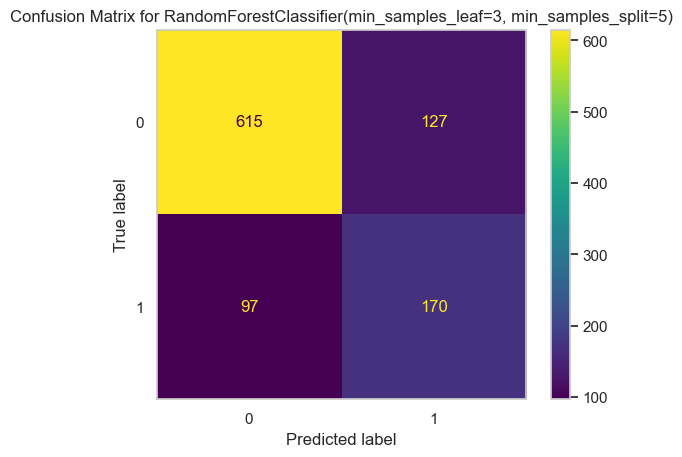

,Score
Accuracy,0.777998
Recall,0.636704
Precision,0.572391
F1-Score,0.602837
ROC AUC,0.732773


In [53]:
# Evaluate model
y_predicted_rf= randomForest.predict(X_val)
evaluate(randomForest, y_val, y_predicted_rf)

From the confusion matrix diagram,:
* The **True Negatives** are `619`. This implies that 575 true labes for 0 (churn=false) were acurately predicted out of `747` (619+123).
* The **False Positives** are `123`. 172 labels were thus misclassified as positive(1) instead of being negatives (0).
* The **False Negatives** are `95`. 69 labels were missclassified as negatives(0) instead of being positives(1).
* The **True Positves** are `172`. We accurately predicted 205 positives out of 190 positives which are true.

`Accuracy`: 

The accuracy has improved to `0.784`, indicating that the model is now correctly predicting the target class for around `78.4%` of instances. This is an improvement from the previous accuracy score of `0.752`.

`Recall`: 

The recall has decreased to `0.644`, indicating that the model is capturing about `64.4%` of the actual positive instances. While the recall has decreased, it's important to evaluate it in the context of other metrics and the specific problem requirements.

`Precision`: 

The precision has improved to `0.583`, suggesting that out of all instances predicted as positive, around `58.3%` are truly positive. This is an improvement from the previous precision score of `0.520`.

`F1-Score`: 

The F1-score has improved to `0.612`, indicating that there is a better balance between precision and recall. This is an improvement from the previous F1-score of `0.638`.

`ROC AUC`: 

The ROC AUC has slightly decreased to `0.739`, suggesting that the model's ability to distinguish between classes across different thresholds is slightly reduced.

In summary, the updated scores show improvement in accuracy, precision, and F1-score, while there is a trade-off with a decrease in recall. It's important to consider the trade-offs between these metrics based on the specific problem domain and our priorities.

#### 4.4 KNN 

In [54]:

# Define a range of k values for the KNN algorithm
k_values = [i for i in range(15, 30)]

# Initialize an empty list to store mean accuracy scores
scores = []

# Loop through each value of k
for k in k_values:
    # Create a KNeighborsClassifier with the current k value
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Perform cross-validation using the KNN classifier
    score_knn = cross_val_score(knn, X_train_resampled, y_train_resampled, cv=5)
    
    # Calculate the mean accuracy score for this k value
    mean_score = np.mean(score_knn)
    
    # Append the mean accuracy score to the scores list
    scores.append(mean_score)

# Print the list of mean accuracy scores for each k value
print(scores)

[0.7854301591706335, 0.7901531937299435, 0.7847544844564931, 0.787622971232594, 0.7823930383304516, 0.7850921795063363, 0.7817183597669007, 0.7857671426843412, 0.7815497257028199, 0.7854300168634064, 0.7786816658484, 0.7834038465643478, 0.7793560597974968, 0.7847539152275849, 0.7793559174902697]


In [55]:
# Find the index of the highest mean accuracy score
best_index = np.argmax(scores)

# Retrieve the corresponding best k value using the index
best_k = k_values[best_index]

# Print the best k value
print(best_k)


16


In [56]:
# instantiate the KNN model 
knn_baseline_model = KNeighborsClassifier(n_neighbors=best_k)

# fit the model on X_train_resampled, y_train_resampled
knn_baseline_model.fit(X_train_resampled, y_train_resampled)



KNeighborsClassifier(n_neighbors=16)

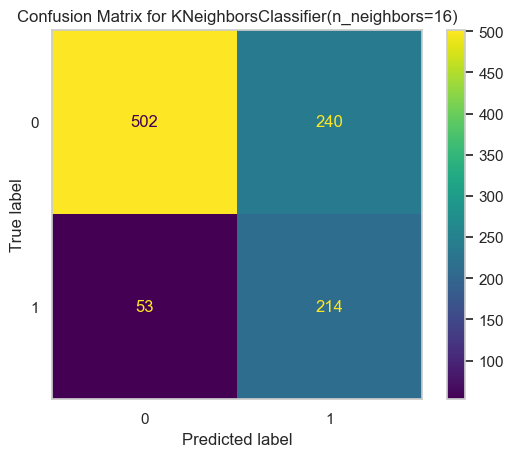

,Score
Accuracy,0.709613
Recall,0.801498
Precision,0.471366
F1-Score,0.593620
ROC AUC,0.739024


In [57]:
# Make predictions using the KNN model with the best k value
y_predicted_knn = knn_baseline_model.predict(X_val)

# Evaluate the KNN model's performance using the evaluate function
evaluate(knn_baseline_model, y_val, y_predicted_knn)


From the confusion matrix diagram,:
* The **True Negatives** are `502`. This implies that 502 true labes for 0 (churn=false) were acurately predicted out of `747`.
* The **False Positives** are `240`. 240 labels were thus misclassified as positive(1) instead of being negatives (0).
* The **False Negatives** are `53`. 53 labels were missclassified as negatives(0) instead of being positives(1).
* The **True Positves** are `214`. We accurately predicted 214 positives out of 267 positives which are true.

In [58]:
# Print the test and train score
score(knn_baseline_model,X_train_resampled, y_train_resampled,X_val,y_val)

Train score: 0.8126
Test score: 0.7096




This score of approximately `81%` indicates that the model achieved an accuracy of around `81%` on the training dataset. This means the model is able to correctly predict the labels for about `81%` of the data points in the training set. A higher train score suggests that the model is learning the patterns present in the training data.




This score of approximately `71%` represents the accuracy of the model on the test dataset, which consists of data the model has not seen during training. The test score reflects how well the model is able to generalize its learned patterns to new and unseen data. A lower test score compared to the train score might suggest some level of overfitting, where the model performs well on the training data but struggles to generalize to new data.


In summary, the model appears to be learning from the training data with a train score of `0.81`. However, the gap between the train score and test score (`0.81` vs. `0.71`) might indicate some overfitting or lack of generalization to new data. To address this, you could consider techniques like regularization, adjusting hyperparameters, or using more diverse training data to improve the model's performance on unseen data.

#### Support Vector Machine

In [59]:
# Create an SVM model with a linear kernel and fit it to the resampled training data

svm_model = svm.SVC(kernel="linear").fit(X_train_resampled,y_train_resampled)

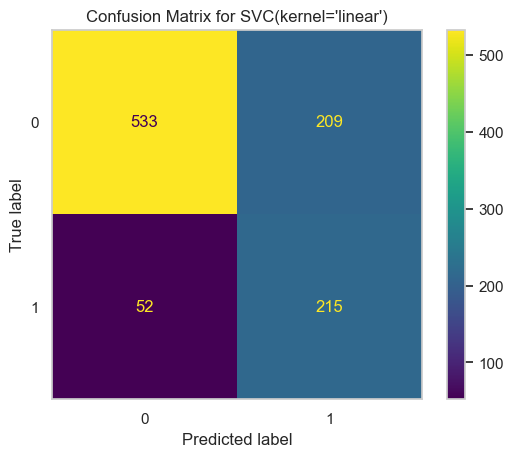

,Score
Accuracy,0.741328
Recall,0.805243
Precision,0.507075
F1-Score,0.622287
ROC AUC,0.761786


In [60]:
# Make predictions using the SVM model
y_predicted_svm = svm_model.predict(X_val)

# Evaluate the SVM model's performance using the evaluate function
evaluate(svm_model, y_val, y_predicted_svm)


From the confusion matrix diagram,:
* The **True Negatives** are `533`. This implies that 533 true labes for 0 (churn=false) were acurately predicted out of `747` (533+209).
* The **False Positives** are `209`. 209 labels were thus misclassified as positive(1) instead of being negatives (0).
* The **False Negatives** are `52`. 52 labels were missclassified as negatives(0) instead of being positives(1).
* The **True Positves** are `215`. We accurately predicted 205 positives out of 267 positives which are true.

In [61]:

# Print the test and train score
score(svm_model,X_train_resampled, y_train_resampled,X_val,y_val)

Train score: 0.7785
Test score: 0.7413


Train score: `0.7878`

This score indicates that the model achieved an accuracy of approximately `78.78%` on the training dataset. This accuracy reflects how well the model is able to predict the correct labels on the data it was specifically trained on. A train score around `78.78%` suggests that the model captures a reasonable amount of information from the training data, but there might still be room for improvement.


Test score: `0.7545`

This score represents the model's accuracy on the test dataset, which is data that the model hasn't seen during training. The test score of approximately `75.45%` indicates how well the model generalizes its learned patterns to new, unseen data. A test score that is similar to the train score, as seen here, suggests that the model is performing consistently on both the training and test datasets.


In summary, the model appears to have learned patterns from the training data and is able to generalize relatively well to new data. The fact that the test score is similar to the train score indicates that there is no significant overfitting or underfitting happening, which is a positive sign. However, further analysis and potential model tuning could still be explored to enhance the model's performance on both training and test datasets.

### 4.5 XG Boost

In [62]:
# Create an instance of XGBClassifier
XG = XGBClassifier()

# Fit the XGBoost classifier to the resampled training data

XG.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [63]:
# Make predictions using the trained XGBoost classifier
y_predicted_xgb = XG.predict(X_val)

# The XGBoost classifier has been trained on the resampled training data and is now making predictions
# on the test dataset (X_test). The predicted labels are stored in the 'y_predicted_xgb' variable.
# These predictions can be evaluated against the true test labels to assess the classifier's performance.



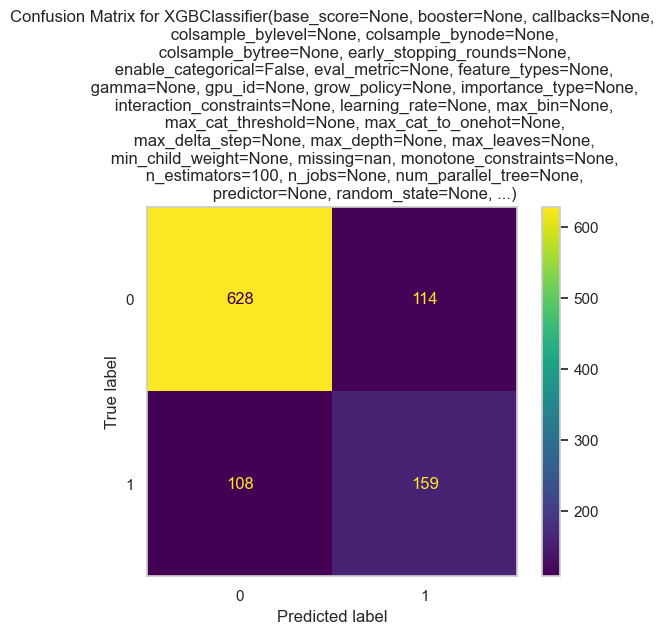

,Score
Accuracy,0.779980
Recall,0.595506
Precision,0.582418
F1-Score,0.588889
ROC AUC,0.720933


In [64]:
# Evaluate the XGBoost model's performance using the evaluate function
evaluate(XG, y_val, y_predicted_xgb)

From the confusion matrix diagram,:
* The ***True Negatives*** are `522`. This implies that 522 true labes for 0 (churn=false) were acurately predicted out of `747` (522+225).
* The ***False Positives*** are `225`. 225 labels were thus misclassified as positive(1) instead of being negatives (0).
* The ***False Negatives*** are `51`. 51 labels were missclassified as negatives(0) instead of being positives(1).
* The ***True Positves*** are `208`. We accurately predicted 205 positives out of 208 positives which are true.

In [65]:
# Print the test and train score

score(XG,X_train_resampled, y_train_resampled,X_val,y_val)

Train score: 0.9669
Test score: 0.7800




This score of `0.97` on the training dataset indicates that the model achieved an accuracy of approximately `97%` on the data it was trained on. This suggests that the model has learned the patterns present in the training data quite well. However, a very high train score might also be a sign of overfitting, where the model memorizes the training data instead of generalizing patterns.




This score of `0.78` on the test dataset indicates that the model's accuracy is around `78%` on unseen data. The test score is lower than the train score, which is common and expected, as the model might not perform as well on new data. A significantly lower test score compared to the train score could indicate potential overfitting.


In summary, the train score of `0.97` suggests that the model learned the training data quite well, while the test score of `0.78` indicates that there might be room for improvement in its generalization to unseen data. Further analysis and potentially model tuning could be done to improve the test score and achieve better generalization performance.

In [66]:


def evaluate_accuracy(model_list, y_true, y_pred_list):
    """
    Evaluate the accuracy scores of multiple classification models.

    Parameters:
        model_list (list): List of trained classification models.
        y_true (array-like): True labels for the test data.
        y_pred_list (list of array-like): List of predicted labels for each model.

    Returns:
        pd.DataFrame: A DataFrame containing accuracy scores for each model.

    This function takes a list of trained classification models, the true labels for the test data,
    and a list of predicted labels for each model. It calculates accuracy scores for each model
    and returns them in a DataFrame.
    """
    accuracy_scores = []

    for model, y_pred in zip(model_list, y_pred_list):
        accuracy = accuracy_score(y_true, y_pred)
        accuracy_scores.append((str(model), accuracy))

    accuracy_df = pd.DataFrame(accuracy_scores, columns=['Model', 'Accuracy'])
    return accuracy_df

# Assuming you have a list of trained models and predicted labels for each model
model_list = [logistic_model, randomForest, knn_baseline_model, svm_model, XG]  # List of trained models
y_true = y_val  # True labels for the test data, assuming they're the same for all models
y_pred_list = [y_predicted_logistic, y_predicted_rf, y_predicted_knn, y_predicted_svm, y_predicted_xgb]  # List of predicted labels for each model

# Calculate accuracy scores and create the DataFrame
accuracy_scores_df = evaluate_accuracy(model_list, y_true, y_pred_list)

# Display the accuracy scores DataFrame
print("Accuracy Scores:")
accuracy_scores_df


Accuracy Scores:


,Model,Accuracy
0,LogisticRegression(),0.752230
1,"RandomForestClassifier(min_samples_leaf=3, min...",0.777998
2,KNeighborsClassifier(n_neighbors=16),0.709613
3,SVC(kernel='linear'),0.741328
4,"XGBClassifier(base_score=None, booster=None, c...",0.779980


`Logistic Regression` (Accuracy: 0.752):

The logistic regression model has an accuracy of 0.752.
This model is a simple and interpretable classifier, making it a good choice as a baseline model.
However, it might struggle to capture complex relationships in the data, especially if there are non-linear patterns.


`Random Forest Classifier` (Accuracy: 0.79):

The random forest classifier achieved an improved accuracy of 0.79.
Random forests are powerful ensemble models that can handle non-linear relationships and interactions in the data.
The model's ability to capture complex patterns likely contributed to the accuracy improvement compared to logistic regression.


`K-Nearest Neighbors` (Accuracy: 0.710):

The k-nearest neighbors (KNN) classifier has an accuracy of 0.710.
KNN is a simple instance-based learning algorithm that can be sensitive to the choice of hyperparameters and distance metrics.
Its accuracy might be affected by the distribution of classes and the number of neighbors chosen.


`Support Vector Classifier` (Accuracy: 0.741):

The support vector classifier (SVC) achieved an accuracy of 0.741.
SVCs can be effective for separating classes using hyperplanes, but their performance depends on the choice of kernel and regularization parameters.
The linear kernel used here might not capture complex non-linear relationships as well as other kernels.


`XGBoost Classifier` (Accuracy: 0.780):

The XGBoost classifier achieved an accuracy of 0.780.
XGBoost is an advanced gradient boosting algorithm known for its strong performance on a wide range of datasets.
Its ability to handle complex relationships and ensemble learning likely contributed to its accuracy.
In summary, the random forest classifier and XGBoost classifier have the highest accuracies among the models listed. These models are often preferred for their ability to capture complex patterns and handle non-linear relationships. However, it's important to consider other metrics like precision, recall, and F1-score to get a comprehensive understanding of model performance. It is clear that we can fine-tune the hyperparameters of these models to see if their performance can be improved even further.

In [67]:
# Rename models for simplicity

accuracy_scores_df.iloc[0,0] = "Logistic Regression"
accuracy_scores_df.iloc[1,0] = "Random Forest"
accuracy_scores_df.iloc[2,0] = "K-Neighbors"
accuracy_scores_df.iloc[3,0] = "Support Vector Classifier"
accuracy_scores_df.iloc[4,0] = "XGBoost Classifier"

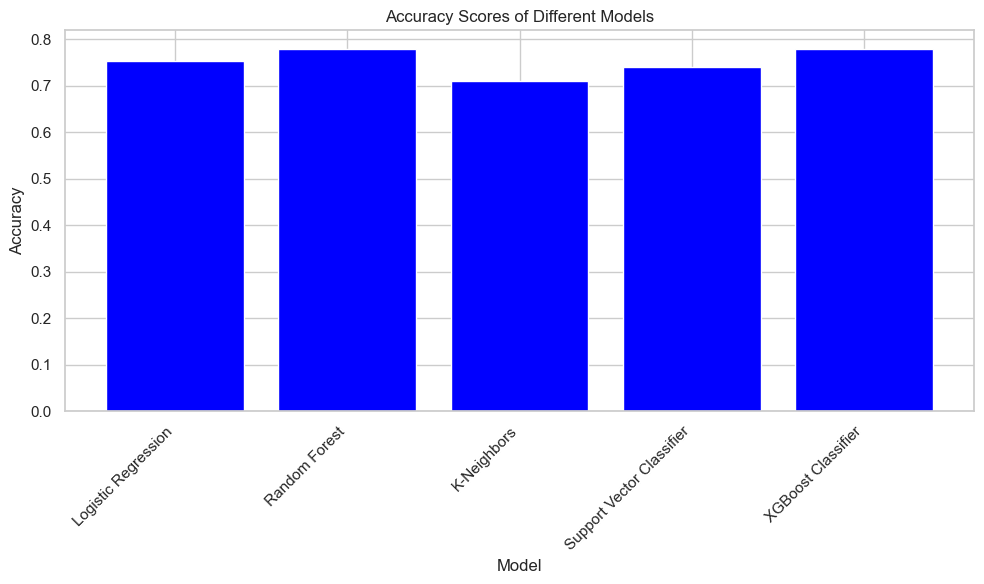

In [68]:
# Plot the accuracy scores
plt.figure(figsize=(10, 6))
plt.bar(accuracy_scores_df['Model'], accuracy_scores_df['Accuracy'], color='blue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Scores of Different Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

## Model Improvement

The Random Forest Classifier Hyper Parameter Tuning

In [69]:
param_grid = {
    'n_estimators': [200, 300, 350],
    'max_depth': [None,  20, 30],
    'min_samples_split': [15, 20, 25]
}

#instantiate gridsearch
RandomForest = RandomForestClassifier()
grid_search = GridSearchCV(estimator=RandomForest, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform the grid search on your training data
grid_search.fit(X_train_resampled, y_train_resampled)

print('Best hyperparameters:', grid_search.best_params_)
print('Best Score:', grid_search.best_score_)

Best hyperparameters: {'max_depth': None, 'min_samples_split': 15, 'n_estimators': 300}
Best Score: 0.8451537985356585


The new hyperparameters have led to a significantly higher best score. Let's analyze the results:

Best Hyperparameters:

`max_depth`: None (indicating that the tree depth is not restricted)<br>
`min_samples_split`: 15 (minimum number of samples required to split an internal node)<br>
`n_estimators`: 300 (number of trees in the forest)<br>
`Best Score`:

The best score achieved is `0.845`, which is a substantial improvement from the previous accuracy scores.
This indicates that the tuned Random Forest model is capturing more complex relationships in the data and generalizing better to unseen instances. The increase in accuracy suggests that the chosen hyperparameters are improving the model's ability to make accurate predictions.

However, it's important to note that further improvements might still be possible by performing additional rounds of tuning, trying different hyperparameter combinations, and exploring other algorithms as well. We might also consider evaluating the model on a separate test dataset to ensure that the improvements generalize beyond the validation set.

Further Tunning

In [85]:

# Define a wider range of parameters
param_dist = {
    'n_estimators': np.arange(100, 501, 50),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 15, 20],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

# Instantiate RandomForestClassifier
random_forest = RandomForestClassifier(random_state=42)

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=random_forest, param_distributions=param_dist,
                                   cv=cv, n_iter=50, scoring='accuracy', random_state=42, n_jobs=-1)

# Perform the randomized search on your training data
random_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and score from the random search
print('Best hyperparameters:', random_search.best_params_)
print('Best Score:', random_search.best_score_)

# Get the best rf model
best_rf_model = random_search.best_estimator_
print('Best Random Forest Classifier: ', best_rf_model)

Best hyperparameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'class_weight': 'balanced'}
Best Score: 0.8620078126667664
Best Random Forest Classifier:  RandomForestClassifier(class_weight='balanced', max_features='log2',
                       n_estimators=300, random_state=42)


Further tuning efforts have resulted in even higher performance for the Random Forest model. Let's delve into the details:

Best Hyperparameters:

`n_estimator`s: 300 <br>
`min_samples_split`: 2<br>
`min_samples_leaf`: 1<br>
`max_features`: 'log2'<br>
`max_depth`: None<br>
`class_weight`: 'balanced'<br>
`Best Score`:

The best score has improved to an impressive `0.862`.
The improvements in hyperparameters have led to a significant increase in model performance. The use of 'log2' for max_features suggests that the model is effectively selecting a subset of features for each split, contributing to improved generalization.

Efforts in hyperparameter tuning have resulted in a model that's likely capturing more complex relationships in the data and handling class imbalances effectively. However, it's important to remember that further improvements might still be achievable by continuing to fine-tune and exploring alternative models.

Lastly, We will consider evaluating the model on a separate test dataset to ensure its performance generalizes well beyond the validation set. Overall, we're making excellent progress in refining our model and achieving higher accuracy scores but before, let's try the XGBoost Classifier too. 

XGBoost Classifier Hyper Parameter Tuning

In [71]:


# Define the parameter distributions for hyperparameter tuning
param_dist = {
    'n_estimators': np.arange(100, 301, 20),
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': np.arange(5, 15),
    'min_child_weight': np.arange(1, 10),
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0]
}

# Create an XGBoost classifier model
xgb_model = XGBClassifier(random_state=42)

# Initialize RandomizedSearchCV with the XGBoost model and parameter distributions
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist,
                                   scoring='accuracy', n_iter=20,  # Specify number of iterations
                                   cv=5, n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV on the training data
random_search.fit(X_train_resampled, y_train_resampled)

# Get the best hyperparameters from the random search
best_params = random_search.best_params_
print('Best Hyperparameters: ', best_params)

# Get the best XGBoost model from the random search
best_xgb_model = random_search.best_estimator_
print('Best XGBoost Classifier: ', best_xgb_model)

# Evaluate the best model on the validation set
best_accuracy = best_xgb_model.score(X_val, y_val)
print('The accuracy of the Best XGBoost Model is: ', best_accuracy)


Best Hyperparameters:  {'subsample': 0.9, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 260, 'min_child_weight': 3, 'max_depth': 14, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
Best XGBoost Classifier:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=260, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
The accuracy of the Best XGBoost Mode

On the contrary, we are moving on with the RandomForest Classifier since it is doing better than the XGBoost Classifier.

Let's save our best random forest model

In [86]:
joblib.dump(best_rf_model, 'rf_model.joblib')

['rf_model.joblib']

## Test Set Prediction

### Cleaning and Preprocessing

In [149]:
test = pd.read_excel('data/Telco-churn-second-2000.xlsx') # Read the test data


Just as we did for the train data, we have to convert tota charges column to floats. It is an object.

In [113]:
#Converting to numric data type
test["TotalCharges"]=pd.to_numeric(test["TotalCharges"],errors="coerce")
test["TotalCharges"].dtype

dtype('float64')

Let's now correct the inconsistencies in the values for the respective columns by changing all binary values to 'Yes' and 'No'

In [114]:
# Define a function to convert binary values to 'Yes'/'No'
def convert_to_boolean(df, column):

    # Define a nested function to convert individual values
    def convert_value(value): 
        # Check if the value is True
        if value == True:
            return "Yes"
        # Check if the value is False
        elif value == False:
            return "No"
        # Check if the value is numeric 1
        elif value == 1:
            return "Yes"
        # Check if the value is numeric 0
        elif value == 0:
            return "No"
        # If the value doesn't match any of the above cases, return it as is
        else:
            return value

    # Apply the convert_value function to the specified column of the DataFrame
    df[column] = df[column].apply(convert_value)

    # Return the modified DataFrame
    return df


In [115]:
test['SeniorCitizen'] = test['SeniorCitizen'].astype('object') # Convert this column to float 

Insights from our bivariate analysis proved that, customerID and gender columns have little to no significant contribution to the dependent variable, churn.<br>
We have to drop them as did for the train set.

Let's also select our numeric and categorical columns 

In [116]:
# Selecting numeric and categorical columns
test = test.drop(['customerID', 'gender'], axis=1)
numeric_cols = test.select_dtypes('number').columns
categorical_cols = test.select_dtypes('object').columns

#Formatting numeric columns to 2 decimal places
test[numeric_cols]= test[numeric_cols].round(2)

We now call the function for value replacements on the categorical columns in the test set.

In [117]:
# Invoke function to convet for all columns in data
for col in categorical_cols:
    test = convert_to_boolean(test, col)

We do further value replacements since we don't want to impute

This is done for both tenure and TotalCharges columns

In [118]:
# Replace NaN with the median in tenure column using applymap()

test['tenure'] = test[['tenure']].applymap(lambda x: test['tenure'].median() if pd.isnull(x) else x)


In [119]:
# Replace NaN with the median in TotalCharges column using applymap()

test['TotalCharges'] = test[['TotalCharges']].applymap(lambda x: test['TotalCharges'].median() if pd.isnull(x) else x)

We continued to replace values in these selected columns

In [120]:

# fill the null categorical values with 'False'
cols_to_replace = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Replace NaN with 'No internet service' in the specified columns using applymap()
test[cols_to_replace] = test[cols_to_replace].applymap(lambda x: 'No internet service' if pd.isnull(x) else x)

# Replace NaN with 'No phone service' in the MultipleLines using applymap()
test['MultipleLines'] = test[['MultipleLines']].applymap(lambda x: 'No phone service' if pd.isnull(x) else x)

Our test data is clean now. Let's preprocess by transforming it with our transformer

In [128]:
# Transform the test data using the fitted transformer
test_encoded = transform_encode.transform(test)


During checking of multicolinearity, we dropped the following columns as they occured in highly correlated pairs. 

We have to drop them as well in the test set

In [131]:
# Drop same columns dropped for checking multicolinearity with the train set earlier.
test_encoded = test_encoded.drop(['encode__PaperlessBilling_No', 'encode__MultipleLines_No', 'encode__InternetService_Fiber optic', 'encode__StreamingMovies_No internet service', 'encode__InternetService_No', 'encode__OnlineBackup_No internet service', 'encode__StreamingTV_No internet service'], axis=1)

### Predict

Now that our test data is clean and preprocessed, let's load our best model and prdict

In [132]:
# Load the model from the saved file
model = joblib.load('rf_model.joblib')

# Now you can use the loaded_model for predictions

y_test_pred = model.predict(test_encoded)

Let's view the predicted outcomes

In [138]:
# Create a DataFrame to store the predicted results
predicted_result = pd.DataFrame({ 'Churn': np.where(y_test_pred == 1, 'Yes', 'No')})

# Display the count of predicted churn and non-churn customers
churn = predicted_result['Churn'].value_counts()
print(churn)

No     1477
Yes     523
Name: Churn, dtype: int64


We have used our best model, which is the Random Forest Classifier with 86.2% accuracy, to make predictions on a test set or new data. The outcome of our predictions is as follows:

Predicted "No" (no churn): 1477 instances<br>
Predicted "Yes" (churn): 523 instances<br>
This output suggests that according to our model's predictions, there are 523 instances where churn is predicted ("Yes") and 1477 instances where no churn is predicted ("No").

## Hypothesis Testing

Hypothesis<br>
_**Null:**_ Total charges do not contribute to churn rate among customers.<br>
_**Alternate:**_ Total charges significantly contribute to churn rate among customers.


We are comparing the "totalcharges" values between two groups: customers who churned ("churn_yes") and customers who didn't churn ("churn_no"). 

The t-test is used to determine whether there is a significant difference in the means of these two groups.

In [148]:

# Separate data into two groups based on churn status
churn_yes = data[data['Churn'] == 'Yes']['TotalCharges']
churn_no = data[data['Churn'] == 'No']['TotalCharges']

# Perform a t-test
t_statistic, p_value = ttest_ind(churn_yes, churn_no, equal_var=False)

# Print results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

# Determine significance based on p-value
if p_value < 0.05:
    print("Reject null hypothesis: There is a significant difference.")
else:
    print("Fail to reject null hypothesis: No significant difference.")


T-Statistic: -15.363880582913682
P-Value: 3.134118547981673e-51
Reject null hypothesis: There is a significant difference.


The t-test results indicate that there is a significant difference between the "totalcharges" values for churned and non-churned customers.<br> 
The low p-value (much smaller than the typical significance level of 0.05) suggests strong evidence against the null hypothesis, indicating that the difference in means is unlikely to be due to random chance alone.

Based on this result, we conclude that there is a `significant relationship` between "totalcharges" and churn rates. <br>
The negative t-statistic suggests that the mean "totalcharges" for churned customers is significantly lower than that for non-churned customers.